# 📊 Data Preprocessing Pipeline

## Overview
This notebook transforms raw news articles into numerical sequences ready for LSTM model training.

## Pipeline Steps
1. **Text Cleaning** - Remove HTML, URLs, special characters
2. **Stopwords Removal** - Remove common words (preserve negations)
3. **Train/Val/Test Split** - 70/15/15 stratified split
4. **Tokenization** - Convert words to numerical IDs
5. **Sequence Padding** - Uniform length sequences
6. **Data Persistence** - Save processed data for training

## Dataset
- **Source:** Merged dataset from exploration notebook
- **Size:** 38,658 articles (fake + real news)
- **Features:** - Title + Text combined

In [1]:
!pip install gensim
!pip install WordCloud
!pip install tensorflow

## 📦 Setup & Imports
Installing required libraries and importing necessary modules.

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import keras
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))
keep_words = {'not', 'no', 'never', 'neither', 'nor'}
stop_words = stop_words - keep_words

## 📂 Load Merged Dataset

Loading the cleanned and merged dataset created in the exploration phase.
This dataset combines fake and real news articles with labels.

In [5]:
df = pd.read_csv('merged_dataset.csv')

In [6]:
df.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  is_true  words_in_title  \
0  Donald Trump just couldn t wish all Americans ...        0              12   
1  House Intelligence Committee Chairman Devin Nu...        0               8   
2  On Friday, it was revealed that former Milwauk...        0              15   
3  On Christmas day, Donald Trump announced that ...        0              14   
4  Pope Francis used his annual Christmas Day mes...        0              11   

   words_in_text  
0            470  
1            308  
2            592  
3            456  
4            420

## 🧹 Data Preparation

Removing unnecessary columns and combining title with text for richer context.

**Why combine title + text?**
- Titles often contain key indicators of fake news (clickbait, sensationalism)
- Combining both provides maximum information to the model

In [7]:
df = df.drop(columns = ['words_in_title', 'words_in_text'], axis = 1)

In [8]:
df['combined_title_text'] = df['title'] + ' ' + df['text']

In [9]:
df.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  is_true  \
0  Donald Trump just couldn t wish all Americans ...        0   
1  House Intelligence Committee Chairman Devin Nu...        0   
2  On Friday, it was revealed that former Milwauk...        0   
3  On Christmas day, Donald Trump announced that ...        0   
4  Pope Francis used his annual Christmas Day mes...        0   

                                 combined_title_text  
0   Donald Trump Sends Out Embarrassing New Year’...  
1   Drunk Bragging Trump Staffer Started Russian ...  
2   Sheriff David Clarke Becomes An Internet Joke...  
3   Trump Is So Obsessed He Even Has Obama’s Name...  
4   Pope Francis Just Called Out Donald Trump Dur...

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
  return TAG_RE.sub('', text)

## 🔧 Text Preprocessing Functions

### Preprocessing Strategy
1. **Remove HTML tags** - Clean web artifacts
2. **Lowercase** - Normalize text
3. **Remove punctuation & numbers** - Focus on words
4. **Remove single characters** - Eliminate noise
5. **Remove stopwords** - Reduce dimensionality (keeping negations!)
6. **Remove short words** - Filter tokens with ≤ 2 chracters

**Important:** Negations like "not", "no", "never" are preserved as they're crucial for detecting fake news patterns.

In [11]:
def preprocess_text(text):
  # To lowercase
  text = text.lower()
  # Remove HTML tags
  text = remove_tags(text)
  # Remove punctuations and numbers
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  # Single character removal
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
  # Remove multiple spaces
  text = re.sub(r'\s+', ' ', text)
  # Remove leading spaces
  text = re.sub(r'^\s+', '', text)
  # Remove Stopwords and remove words with 2 or less characters
  result = []

  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
      result.append(token)

  return result

In [12]:
df['preprocessed_text'] = df['combined_title_text'].apply(preprocess_text)

In [13]:
df.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  is_true  \
0  Donald Trump just couldn t wish all Americans ...        0   
1  House Intelligence Committee Chairman Devin Nu...        0   
2  On Friday, it was revealed that former Milwauk...        0   
3  On Christmas day, Donald Trump announced that ...        0   
4  Pope Francis used his annual Christmas Day mes...        0   

                                 combined_title_text  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                   preprocessed_text  
0  [donald, trump, sends, embarrassing, new, year...  
1  [drunk, bragging, trump, staffer, started, rus...  
2  [sheriff, david, clarke, internet, joke, threa...  
3  [trump, obsessed, obama, coded, website, image...  
4  [pope, francis, called, donald, trump, christm...

In [14]:
print(df['preprocessed_text'][0])

['donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald', 'trump', 'wish', 'americans', 'happy', 'new', 'year', 'leave', 'instead', 'shout', 'enemies', 'haters', 'dishonest', 'fake', 'news', 'media', 'reality', 'star', 'job', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'president', 'angry', 'pants', 'tweeted', 'great', 'year', 'america', 'country', 'rapidly', 'grows', 'stronger', 'smarter', 'want', 'wish', 'friends', 'supporters', 'enemies', 'haters', 'dishonest', 'fake', 'news', 'media', 'happy', 'healthy', 'new', 'year', 'great', 'year', 'america', 'donald', 'trump', 'realdonaldtrump', 'december', 'trump', 'tweet', 'went', 'welll', 'expect', 'kind', 'president', 'sends', 'new', 'year', 'greeting', 'like', 'despicable', 'petty', 'infantile', 'gibberish', 'trump', 'lack', 'decency', 'allow', 'rise', 

In [15]:
df['text_joined'] = df['preprocessed_text'].apply(lambda x: ' '.join(x))

In [16]:
print(df['text_joined'][0])

donald trump sends embarrassing new year eve message disturbing donald trump wish americans happy new year leave instead shout enemies haters dishonest fake news media reality star job country rapidly grows stronger smarter want wish friends supporters enemies haters dishonest fake news media happy healthy new year president angry pants tweeted great year america country rapidly grows stronger smarter want wish friends supporters enemies haters dishonest fake news media happy healthy new year great year america donald trump realdonaldtrump december trump tweet went welll expect kind president sends new year greeting like despicable petty infantile gibberish trump lack decency allow rise gutter long wish american citizens happy new year bishop talbert swan talbertswan december likes calvin calvinstowell december impeachment great year america accept regaining control congress miranda yaver mirandayaver december hear talk include people hate wonder hate alan sandoval alansandoval decembe

## 📊 Exploatory Visualizations

### WordCloud Analysis
Visualizing the most frequent words in real vs fake news to understand linguistic patterns.

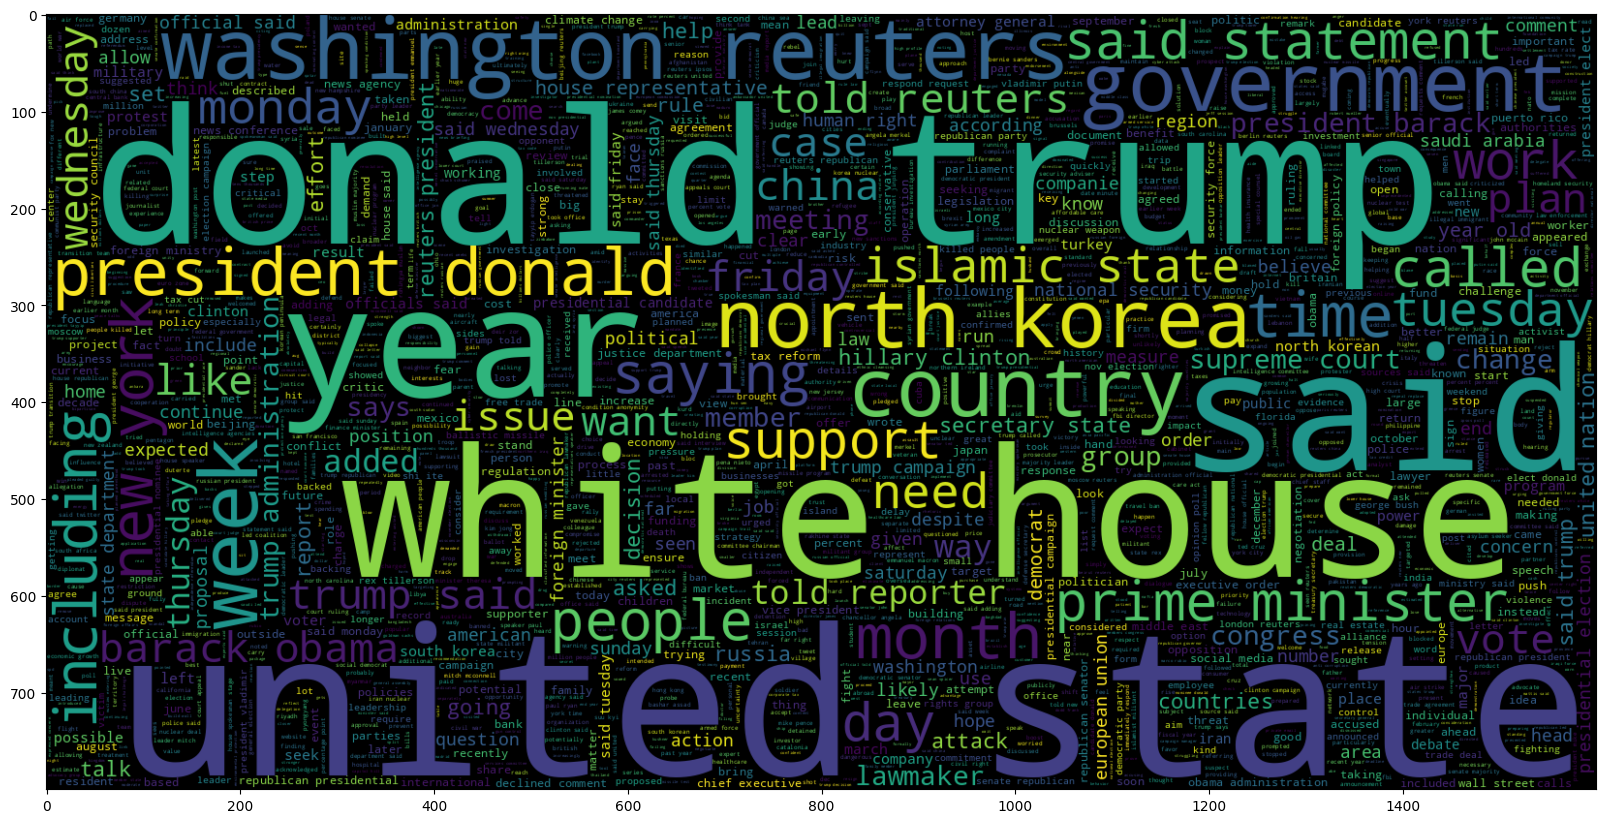

In [17]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = stop_words).generate(' '.join(df[df['is_true'] == 1]['text_joined']))
plt.imshow(wc, interpolation = 'bilinear')

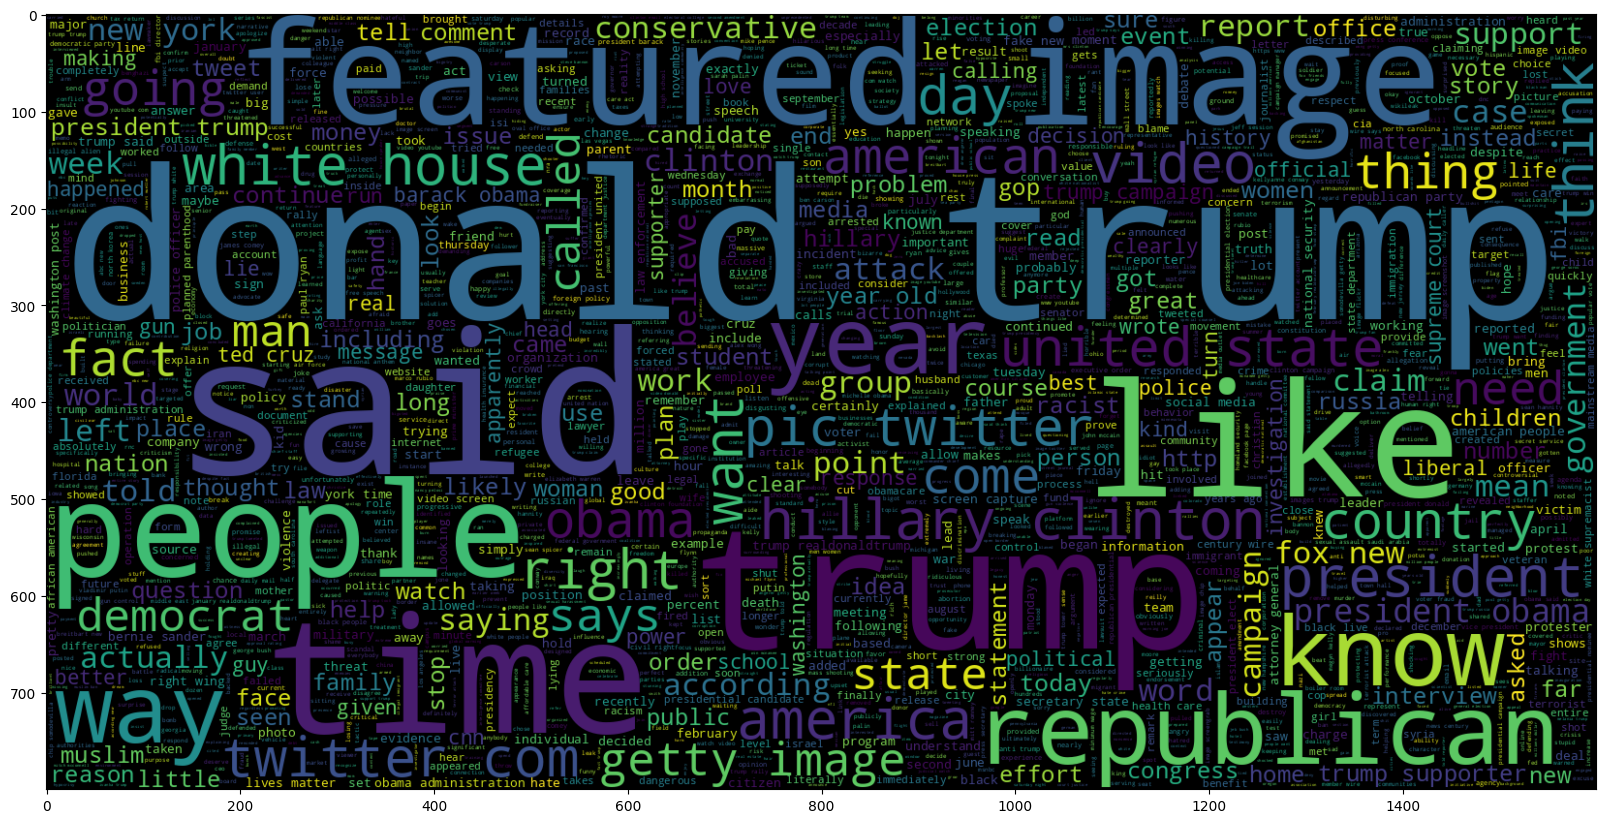

In [18]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = stop_words).generate(' '.join(df[df['is_true'] == 0]['text_joined']))
plt.imshow(wc, interpolation = 'bilinear')

<Axes: xlabel='text_joined', ylabel='Count'>

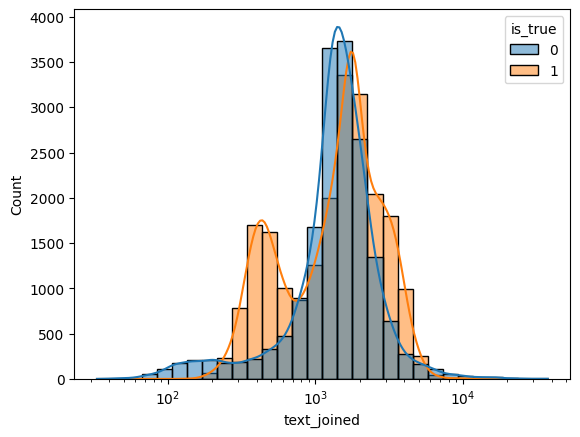

In [19]:
sns.histplot(x = df['text_joined'].str.len(), bins = 30, kde = True, hue = df['is_true'], log_scale = True)

## ✂️ Train/Validation/Text Split

Splitting dataset with stratification to maintain class balance across all sets.

**Split Configuration:**
- **Training:** 70% -> Model learning
- **Validation:** 15% -> Hyperparameter tuning & monitoring
- **Test:** 15% -> Final perfromance evaluation

**Why stratified?** Ensure equal representation of fake/real news in each subset.

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(df['text_joined'], df['is_true'], test_size = 0.3, random_state = 42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42, shuffle = True)

In [21]:
df['number_of_words'] = df['text_joined'].apply(lambda x: len(x.split()))
number_of_words = df['number_of_words'].sum()
print(number_of_words)

8389632


In [22]:
max_words = df['number_of_words'].max()
print(max_words)

4584


## 🔢 Tokkenization

### Converting Text to Numerical Sequences

The LSTM model requires numerical input, so we convert words to integer IDs.

**Process:**
1. Build vocabulary from training set only (prevent data leakaga)
2. Assign unique integer ID to each word
3. Transform all texts to sequences of IDs

**Parameters:**
- `num_words`: Vocabulary size (most frequent words)
- Fitted on `X_train` only to avoid leakage

In [23]:
tokenizer = Tokenizer(num_words = number_of_words)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
validation_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [24]:
print(len(train_sequences))
print(len(validation_sequences))
print(len(test_sequences))

27060
5799
5799


In [25]:
print(train_sequences[0])

[411, 10230, 4924, 13376, 1223, 823, 6182, 6, 411, 10230, 10459, 6182, 85, 5893, 3806, 4, 186, 26, 5986, 2467, 2557, 2467, 10460, 1382, 12802, 307, 1818, 908, 25821, 34529, 3241, 219, 2547, 587, 896, 4025, 3653, 2, 426, 11, 1384, 864, 44701, 618, 3738, 1481, 177, 1813, 56213, 896, 837, 262, 687, 102, 20045, 56214, 2, 13377, 525, 1405, 5893, 3806, 148, 262, 823, 3265, 969, 4989, 2753, 211, 2398, 208, 1405, 3806, 2724, 3738, 2, 1223, 136, 5986, 1327, 1363, 61, 5765, 464, 3171, 5765, 698, 1171, 2047, 1484, 482, 1611, 2467, 3525, 2725, 10346, 671, 8432, 16552, 13171, 2990, 672, 6642, 124, 1146, 6683, 64, 1729, 51, 1870, 2228, 472, 1027, 18840, 5804, 97, 3822, 2557, 477, 1572, 97, 23371, 837, 6434, 1428, 25822, 6801, 15154, 1658, 1223, 44, 5468, 2894, 20762, 867, 1881, 1632, 1219, 4331, 1282, 240, 2, 27440, 16553, 3893, 776, 3475, 29266, 3534]


## 📏 Sequence Length Analysis

Analyzing the distribution of sequences lengths to determine optimal padding length.

<Axes: ylabel='Count'>

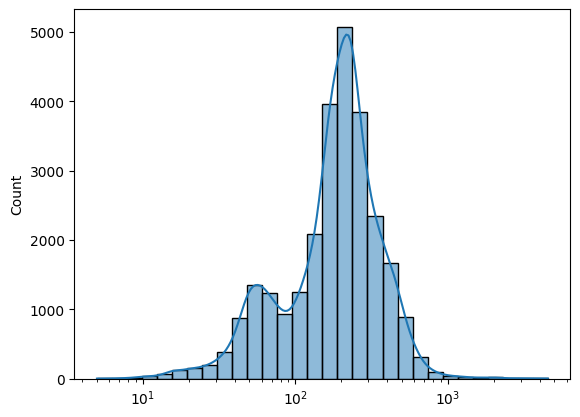

In [26]:
sns.histplot(x = [len(seq) for seq in train_sequences], bins = 30, kde = True, log_scale = True)

## ⚖️ Sequence Padding

Padding all sequences to uniform length for batch processing in LSTM.

**Configuration:**
- `maxlen`: 4584 tokens (maximum length in dataset)
- `padding='post'`: Add zeros at the end
- `truncating='post'`: Cut from the end if too long

**Why post-padding?** Most important information is typically at the beginning of news articles.

In [27]:
padded_train = pad_sequences(train_sequences, maxlen = max_words, padding = 'post', truncating = 'post')
padded_val = pad_sequences(validation_sequences, maxlen = max_words, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = max_words, padding = 'post', truncating = 'post')

In [28]:
print(padded_train[0])

[  411 10230  4924 ...     0     0     0]


## 💾 Save Preprocessed Data

Saving all preprocessed data for model training phase.

**Files to save:**
- `X_train.npy`, `X_val.npy`, `X_test.npy` - Padded sequences
- `y_train.npy`, `y_val.npy`, `y_test.npy` - Labels
- `tokenizer.pkl` - For inference on new data

These files will be loaded in the model training notebook.

In [29]:
np.save('X_train.npy', padded_train)
np.save('X_val.npy', padded_val)
np.save('X_test.npy', padded_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

with open('tokenizer.pkl', 'wb') as f:
  pickle.dump(tokenizer, f)

## ✅ Final Verification

Veryfing shapes, class distributions, and key statistics before proceeding to model training.

In [30]:
print('=' * 50)
print('FINAL SHAPES')
print(f'X_train: {padded_train.shape}')
print(f'X_val:   {padded_val.shape}')
print(f'X_test:  {padded_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val:   {y_val.shape}')
print(f'y_test:  {y_test.shape}')

print('\nCLASS DISTRIBUTION')
print(f'Train - Fake: {sum(y_train == 0)}, Real: {sum(y_train == 1)}')
print(f'Val - Fake:   {sum(y_val == 0)}, Real:   {sum(y_val == 1)}')
print(f'Test - Fake:  {sum(y_test == 0)}, Real: {sum(y_test == 1)}')

print(f'\nVocabulary size:   {len(tokenizer.word_index)}')
print(f'Max sequence length: {max_words}')

FINAL SHAPES
X_train: (27060, 4584)
X_val:   (5799, 4584)
X_test:  (5799, 4584)
y_train: (27060,)
y_val:   (5799,)
y_test:  (5799,)

CLASS DISTRIBUTION
Train - Fake: 12245, Real: 14815
Val - Fake:   2627, Real:   3172
Test - Fake:  2590, Real: 3209

Vocabulary size:   95137
Max sequence length: 4584


## 🎯 Summary & Next Steps

### Preprocessing Complete! ✅

**What we achived:**
- ✅ Cleaned and preprocessed 38,658 news articles
- ✅ Combined titles with text for maximum context
- ✅ Split into train/val/test sets with stratification
- ✅ Tokenized with vocabulary of 95,137 words
- ✅ Padded sequences to uniform length (4,584 tokens)
- ✅ Saved all data for model training

**Key Statistics:**
- Training samples: 27,060
- Validation samples: 5,799
- Test samples: 5,799
- Max sequence length: 4,584 tokens
- Vocabulary size: 95,1377 unique words

### Next Steps:
1. **Build LSTM Architecture** - Design neural network
2. **Train Model** - Fit on training data
3. **Hyperparameter Tuning** - Optimize on validation set
4. **Evaluate Performance** - Test on held-out test set
5. **Error Analysis** - Understand miscalssifications

---

**Ready for:** `03_model_training.ipynb` 🚀